# What is a realistic lower bound to set on cell life?

In [1]:
import napari
from macrohet import dataio, tile, visualise
import os, glob
from tqdm.auto import tqdm

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
expt_ID = 'PS0000'
base_dir = f'/mnt/DATA/macrohet/{expt_ID}/'
metadata_fn = os.path.join(base_dir, 'acquisition/Images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = os.path.join(base_dir, 'acquisition/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
4   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
5   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99
6   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99

# Load tracks

In [7]:
import btrack
print(btrack.__version__)
from skimage.measure import label
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

0.6.1.dev116


In [20]:
acq_ID

(6, 9)

In [24]:
track_dict = {}
# seg_dict = {}
n_masks_per_frame_dict = {}
for acq_ID, data in tqdm(assay_layout.iterrows(), total = len(assay_layout)):
    row, column = acq_ID
    
    tracks_fn = os.path.join(base_dir, f'labels/macrohet_seg_model/{row, column}.h5')
    with btrack.io.HDF5FileHandler(tracks_fn, 'r') as hdf:
        tracks = hdf.tracks
        segmentation = hdf.segmentation
    track_dict[acq_ID] = tracks
    # seg_dict[acq_ID] = segmentation
    n_masks_per_frame = [np.max(label(segmentation[i])) for i in range(len(segmentation))]
    print(n_masks_per_frame)
    n_masks_per_frame_dict[acq_ID] = n_masks_per_frame


  0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2024/01/08 03:31:28 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2024/01/08 03:31:28 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:31:28 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:31:28 PM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2024/01/08 03:31:38 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:31:38 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 4).h5
[INFO][2024/01/08 03:32:24 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/l

[671, 648, 652, 646, 651, 657, 649, 666, 669, 652, 656, 651, 638, 640, 662, 669, 647, 633, 626, 648, 663, 642, 656, 645, 626, 611, 599, 609, 623, 612, 618, 610, 613, 617, 602, 592, 612, 586, 597, 600, 589, 578, 578, 596, 587, 590, 585, 582, 712, 562, 562, 546, 551, 554, 556, 555, 541, 555, 544, 571, 531, 539, 526, 565, 525, 529, 528, 531, 512, 643, 523, 517, 607, 508, 566]


[INFO][2024/01/08 03:32:35 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:32:35 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 5).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 5).h5
[INFO][2024/01/08 03:33:19 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 6).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 6).h5...
[INFO][2024/01/08 03:33:19 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:33:19 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:33:20 PM] Loading objects/obj_type_1 (46507, 5) (46507 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (46507, 5) (46507 filtered: None)


[670, 662, 650, 644, 639, 829, 648, 666, 627, 568, 657, 663, 822, 670, 664, 688, 667, 677, 671, 657, 677, 666, 652, 646, 654, 653, 662, 655, 655, 647, 829, 644, 632, 634, 680, 638, 641, 601, 627, 630, 600, 623, 623, 613, 605, 607, 625, 589, 590, 584, 594, 582, 574, 585, 584, 578, 570, 561, 561, 568, 545, 559, 550, 535, 572, 536, 528, 516, 518, 513, 508, 508, 503, 497, 507]


[INFO][2024/01/08 03:33:30 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:33:30 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 6).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 6).h5
[INFO][2024/01/08 03:34:15 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 7).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 7).h5...
[INFO][2024/01/08 03:34:15 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:34:15 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:34:15 PM] Loading objects/obj_type_1 (42503, 5) (42503 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (42503, 5) (42503 filtered: None)


[694, 658, 686, 663, 669, 670, 686, 677, 683, 694, 692, 690, 711, 790, 712, 708, 698, 700, 692, 692, 712, 712, 691, 703, 701, 737, 708, 717, 933, 789, 697, 722, 912, 698, 692, 673, 695, 706, 862, 701, 707, 674, 685, 1176, 698, 675, 640, 678, 671, 664, 679, 651, 678, 656, 660, 650, 650, 651, 648, 756, 666, 668, 671, 674, 652, 678, 654, 662, 672, 663, 664, 656, 652, 652, 634]


[INFO][2024/01/08 03:34:26 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:34:26 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 7).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 7).h5
[INFO][2024/01/08 03:35:12 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 8).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 8).h5...
[INFO][2024/01/08 03:35:12 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:35:12 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:35:12 PM] Loading objects/obj_type_1 (47396, 5) (47396 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (47396, 5) (47396 filtered: None)


[655, 670, 674, 664, 667, 657, 661, 672, 683, 674, 683, 694, 765, 708, 684, 699, 691, 697, 697, 676, 672, 679, 666, 656, 681, 663, 679, 656, 669, 681, 650, 665, 650, 649, 1072, 637, 657, 921, 666, 628, 637, 693, 604, 797, 616, 587, 601, 607, 606, 610, 609, 620, 608, 584, 601, 605, 578, 594, 597, 600, 570, 567, 573, 584, 567, 560, 580, 563, 573, 572, 571, 559, 563, 568, 558]


[INFO][2024/01/08 03:35:22 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:35:22 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 8).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 8).h5
[INFO][2024/01/08 03:36:09 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 9).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 9).h5...
[INFO][2024/01/08 03:36:09 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:36:09 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:36:09 PM] Loading objects/obj_type_1 (42259, 5) (42259 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (42259, 5) (42259 filtered: None)


[711, 697, 694, 689, 719, 692, 674, 692, 721, 764, 732, 717, 737, 741, 744, 765, 770, 757, 756, 765, 773, 815, 740, 737, 736, 729, 737, 739, 721, 710, 719, 716, 707, 692, 710, 691, 693, 688, 685, 705, 681, 678, 675, 687, 664, 667, 670, 667, 672, 686, 681, 695, 683, 679, 689, 683, 666, 684, 677, 671, 656, 651, 643, 652, 656, 653, 645, 631, 652, 660, 651, 673, 648, 657, 652]


[INFO][2024/01/08 03:36:18 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:36:18 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 9).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(3, 9).h5
[INFO][2024/01/08 03:37:01 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2024/01/08 03:37:01 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:37:01 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:37:01 PM] Loading objects/obj_type_1 (41640, 5) (41640 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (41640, 5) (41640 filtered: None)


[578, 595, 571, 596, 585, 608, 588, 613, 643, 642, 644, 621, 649, 637, 635, 621, 622, 637, 644, 637, 653, 639, 623, 618, 630, 628, 627, 630, 625, 629, 626, 638, 639, 624, 628, 628, 625, 622, 631, 625, 634, 617, 617, 610, 597, 610, 601, 595, 613, 599, 626, 594, 591, 597, 597, 609, 603, 608, 590, 583, 588, 591, 583, 587, 595, 586, 585, 584, 584, 582, 570, 574, 566, 712, 566]


[INFO][2024/01/08 03:37:10 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:37:10 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 4).h5
[INFO][2024/01/08 03:37:57 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 5).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2024/01/08 03:37:57 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:37:57 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:37:57 PM] Loading objects/obj_type_1 (47242, 5) (47242 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (47242, 5) (47242 filtered: None)


[707, 690, 680, 699, 699, 687, 841, 686, 682, 1092, 1034, 691, 688, 668, 679, 712, 1286, 739, 658, 671, 665, 645, 649, 679, 639, 628, 622, 632, 636, 652, 636, 649, 728, 653, 638, 633, 635, 630, 633, 622, 603, 606, 604, 612, 617, 596, 600, 621, 596, 607, 588, 605, 603, 594, 611, 604, 587, 577, 593, 548, 618, 549, 564, 570, 560, 552, 575, 554, 551, 554, 560, 545, 562, 547, 546]


[INFO][2024/01/08 03:38:08 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:38:08 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 5).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 5).h5
[INFO][2024/01/08 03:38:54 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 6).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 6).h5...
[INFO][2024/01/08 03:38:54 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:38:54 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:38:54 PM] Loading objects/obj_type_1 (43883, 5) (43883 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (43883, 5) (43883 filtered: None)


[683, 759, 679, 672, 867, 699, 688, 721, 713, 743, 740, 738, 749, 731, 715, 733, 747, 740, 752, 804, 760, 739, 742, 746, 736, 737, 736, 718, 781, 759, 803, 716, 725, 721, 729, 735, 723, 742, 712, 698, 707, 720, 708, 704, 718, 712, 697, 693, 692, 698, 692, 686, 668, 666, 658, 652, 651, 645, 639, 627, 627, 606, 596, 585, 579, 564, 571, 547, 548, 538, 525, 508, 489, 489, 468]


[INFO][2024/01/08 03:39:04 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:39:04 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 6).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 6).h5
[INFO][2024/01/08 03:39:48 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 7).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 7).h5...
[INFO][2024/01/08 03:39:48 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:39:48 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:39:48 PM] Loading objects/obj_type_1 (42965, 5) (42965 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (42965, 5) (42965 filtered: None)


[784, 629, 628, 629, 628, 639, 649, 647, 656, 662, 668, 666, 667, 682, 685, 684, 685, 687, 703, 709, 705, 721, 693, 715, 713, 710, 705, 690, 699, 679, 709, 684, 682, 659, 682, 709, 664, 660, 703, 641, 651, 647, 643, 646, 638, 630, 631, 626, 628, 610, 597, 601, 603, 617, 605, 595, 609, 606, 597, 582, 586, 585, 575, 608, 573, 566, 578, 558, 560, 549, 545, 549, 541, 532, 524]


[INFO][2024/01/08 03:39:59 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:39:59 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 7).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 7).h5
[INFO][2024/01/08 03:40:44 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 8).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 8).h5...
[INFO][2024/01/08 03:40:44 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:40:44 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:40:45 PM] Loading objects/obj_type_1 (38895, 5) (38895 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (38895, 5) (38895 filtered: None)


[655, 661, 721, 703, 711, 718, 707, 700, 713, 701, 715, 730, 709, 712, 712, 702, 704, 708, 694, 685, 692, 693, 676, 663, 670, 664, 671, 686, 693, 677, 778, 664, 672, 658, 628, 656, 665, 649, 701, 652, 634, 640, 639, 644, 627, 631, 619, 657, 683, 619, 606, 623, 606, 611, 602, 606, 622, 590, 605, 606, 605, 572, 566, 578, 594, 569, 566, 569, 563, 528, 892, 540, 548, 533, 566]


[INFO][2024/01/08 03:40:54 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:40:54 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 8).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 8).h5
[INFO][2024/01/08 03:41:36 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 9).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 9).h5...
[INFO][2024/01/08 03:41:36 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:41:36 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:41:37 PM] Loading objects/obj_type_1 (44643, 5) (44643 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (44643, 5) (44643 filtered: None)


[555, 581, 557, 587, 602, 617, 606, 589, 603, 602, 603, 611, 612, 619, 607, 625, 614, 612, 597, 611, 617, 604, 597, 601, 615, 603, 600, 633, 598, 596, 590, 585, 597, 598, 588, 588, 600, 592, 671, 588, 574, 583, 570, 571, 584, 565, 559, 563, 552, 588, 559, 571, 550, 550, 919, 588, 545, 538, 530, 543, 528, 533, 518, 512, 526, 509, 518, 530, 494, 490, 508, 487, 482, 483, 477]


[INFO][2024/01/08 03:41:47 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:41:47 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 9).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(4, 9).h5
[INFO][2024/01/08 03:42:32 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 4).h5...
[INFO][2024/01/08 03:42:32 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:42:32 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:42:32 PM] Loading objects/obj_type_1 (30664, 5) (30664 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (30664, 5) (30664 filtered: None)


[660, 663, 661, 690, 666, 664, 664, 676, 690, 703, 699, 719, 722, 733, 722, 733, 724, 706, 737, 708, 696, 713, 703, 720, 696, 696, 693, 690, 696, 692, 670, 688, 691, 696, 677, 683, 666, 665, 665, 652, 652, 652, 639, 650, 673, 632, 632, 642, 624, 619, 605, 601, 602, 633, 611, 592, 605, 596, 612, 729, 706, 599, 819, 765, 604, 661, 571, 554, 570, 639, 547, 552, 548, 552, 550]


[INFO][2024/01/08 03:42:42 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:42:42 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 4).h5
[INFO][2024/01/08 03:43:23 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 5).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 5).h5...
[INFO][2024/01/08 03:43:23 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:43:23 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:43:23 PM] Loading objects/obj_type_1 (42973, 5) (42973 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (42973, 5) (42973 filtered: None)


[506, 523, 514, 508, 517, 513, 517, 516, 521, 509, 511, 522, 520, 504, 521, 510, 515, 504, 499, 509, 746, 494, 513, 488, 498, 502, 481, 502, 487, 481, 481, 489, 483, 572, 481, 485, 470, 492, 483, 639, 479, 471, 482, 473, 465, 459, 449, 455, 449, 453, 448, 431, 425, 434, 448, 438, 457, 418, 413, 407, 404, 419, 396, 401, 411, 393, 390, 381, 394, 501, 376, 375, 389, 372, 380]


[INFO][2024/01/08 03:43:34 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:43:34 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 5).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 5).h5
[INFO][2024/01/08 03:44:20 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 6).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 6).h5...
[INFO][2024/01/08 03:44:20 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:44:20 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:44:20 PM] Loading objects/obj_type_1 (45678, 5) (45678 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (45678, 5) (45678 filtered: None)


[693, 676, 678, 675, 650, 667, 663, 657, 658, 672, 720, 671, 751, 675, 670, 692, 650, 679, 663, 680, 667, 691, 690, 685, 674, 686, 687, 685, 677, 679, 704, 673, 667, 647, 659, 638, 653, 659, 640, 639, 641, 637, 629, 623, 626, 641, 622, 621, 616, 643, 621, 608, 620, 798, 601, 610, 579, 578, 591, 579, 772, 563, 556, 548, 544, 524, 532, 519, 525, 512, 530, 503, 502, 480, 471]


[INFO][2024/01/08 03:44:31 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:44:31 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 6).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 6).h5
[INFO][2024/01/08 03:45:19 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 7).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 7).h5...
[INFO][2024/01/08 03:45:19 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:45:19 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:45:19 PM] Loading objects/obj_type_1 (47880, 5) (47880 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (47880, 5) (47880 filtered: None)


[705, 692, 666, 691, 695, 698, 679, 675, 733, 690, 703, 724, 741, 711, 714, 711, 704, 736, 705, 744, 703, 695, 703, 697, 697, 718, 708, 695, 717, 698, 686, 695, 693, 688, 695, 684, 682, 695, 760, 674, 692, 680, 680, 663, 687, 662, 685, 677, 659, 675, 660, 674, 663, 674, 662, 642, 645, 638, 657, 649, 647, 644, 643, 630, 623, 613, 615, 628, 624, 606, 595, 589, 594, 600, 592]


[INFO][2024/01/08 03:45:28 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:45:28 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 7).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 7).h5
[INFO][2024/01/08 03:46:17 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 8).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 8).h5...
[INFO][2024/01/08 03:46:17 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:46:17 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:46:17 PM] Loading objects/obj_type_1 (38531, 5) (38531 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (38531, 5) (38531 filtered: None)


[741, 709, 728, 736, 751, 752, 1166, 734, 718, 739, 748, 737, 738, 805, 745, 754, 720, 745, 743, 738, 732, 721, 781, 824, 769, 746, 714, 737, 723, 704, 699, 720, 739, 688, 703, 718, 702, 703, 730, 692, 697, 729, 688, 680, 677, 690, 697, 678, 712, 705, 704, 691, 714, 718, 704, 696, 700, 689, 706, 696, 708, 685, 725, 694, 704, 686, 686, 690, 692, 705, 697, 681, 700, 684, 685]


[INFO][2024/01/08 03:46:28 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:46:28 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 8).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 8).h5
[INFO][2024/01/08 03:47:10 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 9).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 9).h5...
[INFO][2024/01/08 03:47:10 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:47:10 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:47:10 PM] Loading objects/obj_type_1 (33081, 5) (33081 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (33081, 5) (33081 filtered: None)


[595, 591, 589, 593, 592, 605, 601, 583, 605, 599, 610, 603, 615, 631, 609, 607, 626, 608, 611, 635, 604, 617, 619, 628, 642, 622, 645, 606, 615, 612, 628, 620, 621, 645, 612, 611, 591, 604, 608, 597, 587, 599, 591, 595, 604, 587, 569, 569, 560, 576, 543, 566, 548, 551, 539, 551, 534, 530, 527, 517, 523, 514, 525, 522, 516, 520, 514, 523, 519, 529, 531, 514, 516, 557, 498]


[INFO][2024/01/08 03:47:21 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:47:21 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 9).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(5, 9).h5
[INFO][2024/01/08 03:48:06 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2024/01/08 03:48:06 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:48:06 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1


[630, 622, 642, 661, 654, 627, 639, 648, 649, 642, 649, 653, 654, 621, 645, 656, 1993, 722, 652, 663, 664, 762, 651, 677, 685, 665, 666, 1163, 676, 706, 707, 660, 669, 643, 626, 588, 592, 587, 569, 550, 539, 513, 501, 511, 485, 471, 445, 444, 427, 407, 398, 380, 363, 349, 336, 330, 322, 307, 294, 286, 279, 273, 274, 262, 248, 248, 240, 238, 218, 217, 214, 202, 202, 205, 197]


[INFO][2024/01/08 03:48:07 PM] Loading objects/obj_type_1 (42961, 5) (42961 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (42961, 5) (42961 filtered: None)
[INFO][2024/01/08 03:48:17 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:48:17 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 4).h5
[INFO][2024/01/08 03:49:05 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 5).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2024/01/08 03:49:05 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:49:05 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:49:05 PM] Loading objects/obj_type_1 (46808, 5) (46808 

[705, 679, 715, 698, 686, 717, 708, 691, 690, 720, 742, 1033, 729, 730, 745, 736, 726, 718, 779, 906, 734, 698, 723, 691, 689, 685, 739, 675, 674, 693, 1760, 710, 718, 672, 650, 665, 639, 651, 653, 646, 664, 623, 683, 635, 616, 644, 617, 622, 602, 619, 625, 597, 601, 609, 590, 593, 586, 599, 577, 583, 577, 577, 759, 585, 621, 566, 574, 575, 566, 555, 559, 566, 562, 564, 545]


[INFO][2024/01/08 03:49:16 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:49:16 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 5).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 5).h5
[INFO][2024/01/08 03:50:02 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 6).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 6).h5...
[INFO][2024/01/08 03:50:02 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:50:02 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:50:02 PM] Loading objects/obj_type_1 (45688, 5) (45688 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (45688, 5) (45688 filtered: None)


[728, 760, 730, 726, 726, 728, 727, 719, 740, 2308, 728, 734, 860, 736, 972, 915, 730, 750, 747, 720, 727, 752, 725, 741, 736, 819, 743, 721, 927, 885, 713, 724, 745, 959, 744, 883, 710, 700, 696, 872, 706, 687, 682, 669, 680, 687, 683, 689, 679, 664, 668, 654, 646, 641, 652, 670, 649, 645, 634, 632, 644, 625, 615, 611, 670, 606, 582, 584, 591, 578, 542, 534, 548, 537, 550]


[INFO][2024/01/08 03:50:12 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:50:12 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 6).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 6).h5
[INFO][2024/01/08 03:51:00 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 7).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2024/01/08 03:51:00 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:51:00 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:51:00 PM] Loading objects/obj_type_1 (45214, 5) (45214 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (45214, 5) (45214 filtered: None)


[696, 720, 710, 708, 725, 728, 717, 732, 775, 756, 737, 747, 852, 732, 730, 732, 739, 733, 701, 727, 734, 731, 759, 718, 791, 744, 720, 696, 697, 688, 704, 692, 705, 700, 699, 685, 692, 676, 691, 689, 687, 676, 705, 674, 685, 677, 674, 669, 665, 652, 659, 705, 650, 652, 634, 650, 643, 634, 639, 630, 623, 613, 622, 621, 611, 666, 623, 613, 596, 598, 600, 600, 739, 588, 584]


[INFO][2024/01/08 03:51:09 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:51:09 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 7).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 7).h5
[INFO][2024/01/08 03:51:58 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 8).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 8).h5...
[INFO][2024/01/08 03:51:58 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:51:58 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:51:58 PM] Loading objects/obj_type_1 (46267, 5) (46267 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (46267, 5) (46267 filtered: None)


[674, 679, 671, 669, 693, 684, 734, 715, 720, 715, 726, 742, 741, 731, 716, 720, 708, 719, 705, 756, 711, 691, 699, 692, 697, 697, 690, 676, 683, 773, 678, 800, 677, 672, 685, 662, 668, 661, 647, 653, 659, 656, 652, 665, 672, 668, 655, 640, 641, 641, 646, 641, 971, 646, 638, 670, 670, 646, 642, 635, 634, 676, 635, 629, 638, 654, 627, 625, 639, 627, 643, 630, 614, 616, 633]


[INFO][2024/01/08 03:52:09 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:52:09 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 8).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 8).h5
[INFO][2024/01/08 03:52:56 PM] Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 9).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 9).h5...
[INFO][2024/01/08 03:52:56 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/08 03:52:56 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/08 03:52:56 PM] Loading objects/obj_type_1 (35615, 5) (35615 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (35615, 5) (35615 filtered: None)


[728, 731, 752, 754, 760, 756, 773, 744, 760, 941, 788, 790, 771, 775, 793, 777, 783, 782, 745, 747, 742, 759, 755, 787, 794, 744, 747, 739, 739, 1283, 724, 702, 753, 1019, 738, 708, 4013, 683, 1675, 1572, 673, 839, 687, 716, 678, 680, 654, 724, 669, 666, 639, 650, 644, 732, 631, 648, 634, 707, 1398, 632, 653, 658, 622, 1945, 1390, 633, 780, 938, 628, 701, 754, 618, 599, 819, 701]


[INFO][2024/01/08 03:53:06 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/01/08 03:53:06 PM] Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 9).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/PS0000/labels/macrohet_seg_model/(6, 9).h5


[636, 667, 668, 659, 683, 676, 680, 866, 680, 691, 710, 700, 725, 702, 702, 826, 702, 689, 666, 680, 693, 682, 659, 688, 684, 698, 660, 654, 681, 675, 661, 636, 634, 610, 620, 614, 598, 574, 557, 558, 539, 534, 519, 502, 523, 487, 487, 456, 438, 442, 430, 410, 400, 397, 383, 385, 380, 371, 351, 398, 336, 331, 321, 329, 323, 308, 300, 282, 283, 274, 273, 271, 279, 255, 274]


In [22]:
n_masks_per_frame_dict

{(3, 4): [671,
  648,
  652,
  646,
  651,
  657,
  649,
  666,
  669,
  652,
  656,
  651,
  638,
  640,
  662,
  669,
  647,
  633,
  626,
  648,
  663,
  642,
  656,
  645,
  626,
  611,
  599,
  609,
  623,
  612,
  618,
  610,
  613,
  617,
  602,
  592,
  612,
  586,
  597,
  600,
  589,
  578,
  578,
  596,
  587,
  590,
  585,
  582,
  712,
  562,
  562,
  546,
  551,
  554,
  556,
  555,
  541,
  555,
  544,
  571,
  531,
  539,
  526,
  565,
  525,
  529,
  528,
  531,
  512,
  643,
  523,
  517,
  607,
  508,
  566],
 (3, 5): [670,
  662,
  650,
  644,
  639,
  829,
  648,
  666,
  627,
  568,
  657,
  663,
  822,
  670,
  664,
  688,
  667,
  677,
  671,
  657,
  677,
  666,
  652,
  646,
  654,
  653,
  662,
  655,
  655,
  647,
  829,
  644,
  632,
  634,
  680,
  638,
  641,
  601,
  627,
  630,
  600,
  623,
  623,
  613,
  605,
  607,
  625,
  589,
  590,
  584,
  594,
  582,
  574,
  585,
  584,
  578,
  570,
  561,
  561,
  568,
  545,
  559,
  550,
  535,
  572,
  5

  0%|          | 0/2 [00:00<?, ?it/s]

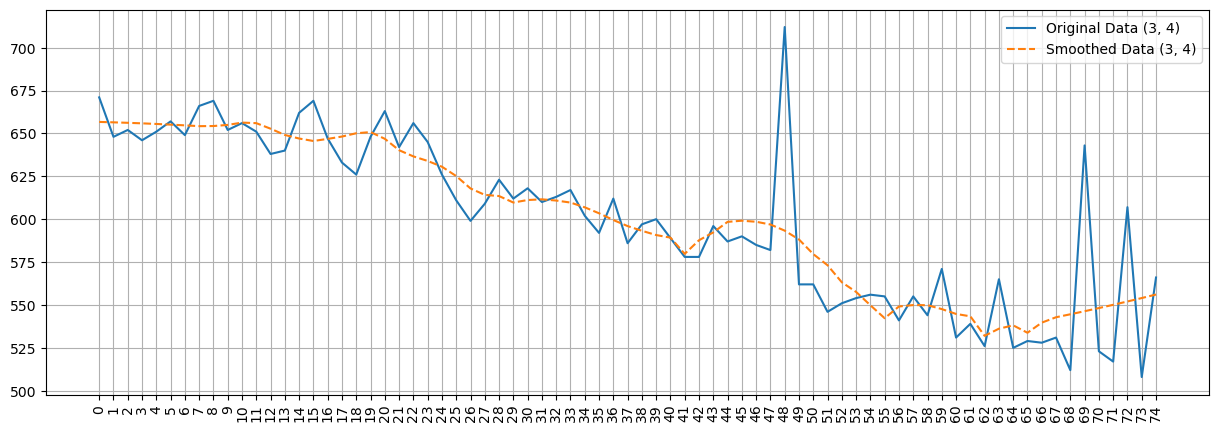

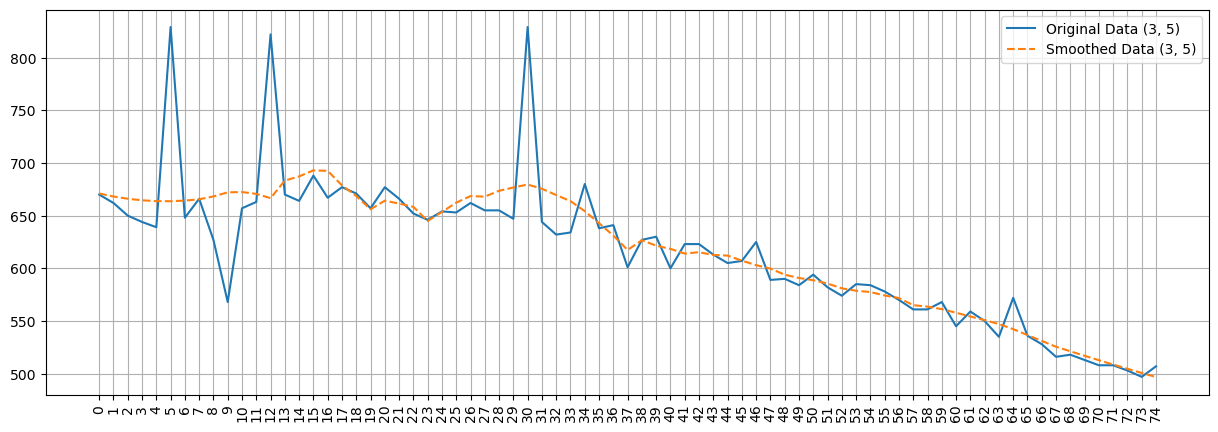

In [23]:
for acq_ID in tqdm(n_masks_per_frame_dict.keys(), total=len(n_masks_per_frame_dict)):
    
    plt.figure(figsize=(15, 5))  
    n_masks_per_frame = n_masks_per_frame_dict[acq_ID]
    
    # Smooth the data using a Savitzky-Golay filter
    window_length = 15  # Adjust the window length as needed
    smoothed_data = savgol_filter(n_masks_per_frame, window_length, 2)  # The '2' is the order of the smoothing
    
    # Plot the original data
    plt.plot(n_masks_per_frame, label=f'Original Data {acq_ID}')
    
    # Plot the smoothed data on top
    plt.plot(smoothed_data, label=f'Smoothed Data {acq_ID}', linestyle='--')

    # Specify the locations of vertical grid lines
    x_values = range(len(n_masks_per_frame))
    plt.xticks(x_values, rotation=90)  # Rotate x-labels by 90 degrees
    
    # Add grid lines
    plt.grid()
    
    # Add a legend to differentiate between the original and smoothed data
    plt.legend()
    
    # Show the plot
    plt.show()

In [16]:
len([t for t in tracks if t.in_frame(0)])

615

In [17]:
test = 

SyntaxError: invalid syntax (4042111915.py, line 1)

In [ ]:
# Smooth the data using a Savitzky-Golay filter
window_length = 15  # Adjust the window length as needed
smoothed_data = savgol_filter(n_masks_per_frame, window_length, 2)  # The '2' is the order of the smoothing

# Set the figure size
plt.figure(figsize=(15, 5))  # Adjust the width (10) and height (5) as needed

# Plot the original data
plt.plot(n_masks_per_frame, label='Original Data')

# Plot the smoothed data on top
plt.plot(smoothed_data, label='Smoothed Data', linestyle='--')

# Specify the locations of vertical grid lines
x_values = range(len(n_masks_per_frame))
plt.xticks(x_values, rotation=90)  # Rotate x-labels by 90 degrees

# Add grid lines
plt.grid()

# Add a legend to differentiate between the original and smoothed data
plt.legend()

# Show the plot
plt.show()

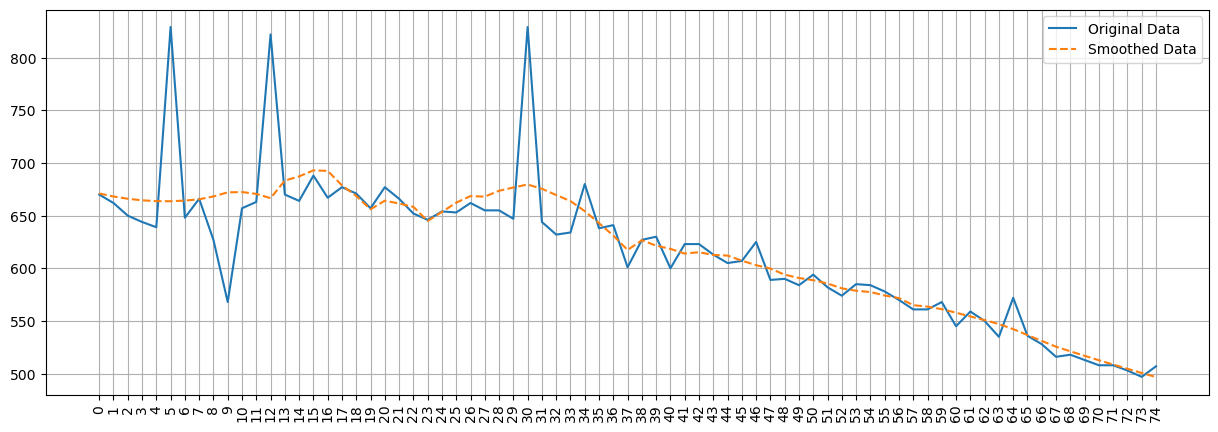

In [76]:
# Smooth the data using a Savitzky-Golay filter
window_length = 15  # Adjust the window length as needed
smoothed_data = savgol_filter(n_masks_per_frame, window_length, 2)  # The '2' is the order of the smoothing

# Set the figure size
plt.figure(figsize=(15, 5))  # Adjust the width (10) and height (5) as needed

# Plot the original data
plt.plot(n_masks_per_frame, label='Original Data')

# Plot the smoothed data on top
plt.plot(smoothed_data, label='Smoothed Data', linestyle='--')

# Specify the locations of vertical grid lines
x_values = range(len(n_masks_per_frame))
plt.xticks(x_values, rotation=90)  # Rotate x-labels by 90 degrees

# Add grid lines
plt.grid()

# Add a legend to differentiate between the original and smoothed data
plt.legend()

# Show the plot
plt.show()

In [12]:
import json
dict_fn = f'/mnt/DATA/macrohet/{expt_ID}/upstream_development/tracking/tracking_performance/v1>70/{row},{column}/{acq_ID}_track_assessment.json'
with open(dict_fn) as json_data:
    track_dict = json.load(json_data)
true_IDs = [int(ID) for ID in track_dict.keys() if track_dict[ID] == True]
true_tracks = [t for t in tracks if t.ID in true_IDs]
napari_true_tracks, properties, graph = btrack.utils.tracks_to_napari(true_tracks, ndim=2)

### Recolour tracks

In [13]:
col_segmentation = btrack.utils.update_segmentation(segmentation, true_tracks, scale = (5.04, 5.04))

# Launch napari image viewer

In [14]:
# # %time
# viewer = napari.Viewer(title = f'{row, column}')

# viewer.add_image(images, 
#                  channel_axis=1,
#                  name=["macrophage", "mtb"],
#                  colormap=["green",  "magenta"],
# #                  contrast_limits=[[100, 6000], [100, 2000]],
#                  contrast_limits=[[0,450], [0,450]], 
#                  visible = True
#                  )
# viewer.add_image(images, 
#                  channel_axis=1,
#                  name=["macrophage", "mtb"],
#                  colormap=["green",  "magenta"],
# #                  contrast_limits=[[100, 6000], [100, 2000]],
# #                  contrast_limits=[[0,450], [0,450]], 
#                  visible = True
#                  )
viewer.add_labels(segmentation, 
#                   num_colors= 1,
                  #scale=(10, 1, 1,), 
                  #color='yellow'
                  name = 'segmentation'
                 )
# viewer.add_labels(col_segmentation, 
#                   name = 'recolored segmentation'
#                   #scale=(10, 1, 1,), 
#                   #color='yellow'
#                  )
# viewer.add_tracks(napari_tracks, scale = (1,5.04,5.04)
# #                     properties=properties, 
# #                     graph=graph, 
# #                     name="Properly downscaled tracks", 
# #                     blending="translucent",
# #                     visible=True,
# # #                     scale = (100,1,1)
#                  )
viewer.add_tracks(napari_true_tracks, scale = (1,5.04,5.04),
#                     properties=properties, 
#                     graph=graph, 
#                     name="Properly downscaled tracks", 
#                     blending="translucent",
#                     visible=True,
# #                     scale = (100,1,1)
                 )

<Tracks layer 'napari_true_tracks' at 0x7fb5632619d0>

In [26]:
visualise.highlight_cell(507, viewer, tracks)

<Points layer 'cell 507 [1]' at 0x7f7586e5af10>

In [17]:
sd_2_75 = ['444.3.5',
 '530.3.5',
 '542.3.5',
 '552.3.5',
 '602.3.5',
 '1118.3.5',
 '1129.3.5',
 '628.3.5',
 '642.3.5',
 '131.3.5',
 '204.3.5',
 '1356.3.5',
 '344.3.5',
 '410.3.5',
 '461.3.5',
 '997.3.5',
 '493.3.5']

sd_2_5 = ['218.3.5',
 '44.3.5',
 '444.3.5',
 '447.3.5',
 '507.3.5',
 '51.3.5',
 '530.3.5',
 '542.3.5',
 '552.3.5',
 '602.3.5',
 '64.3.5',
 '585.3.5',
 '1611.3.5',
 '89.3.5',
 '1118.3.5',
 '1129.3.5',
 '628.3.5',
 '642.3.5',
 '131.3.5',
 '204.3.5',
 '1356.3.5',
 '344.3.5',
 '410.3.5',
 '461.3.5',
 '997.3.5',
 '493.3.5']

sd_3 = ['444.3.5',
 '530.3.5',
 '542.3.5',
 '552.3.5',
 '1118.3.5',
 '1129.3.5',
 '628.3.5',
 '642.3.5',
 '131.3.5',
 '204.3.5',
 '1356.3.5',
 '344.3.5',
 '461.3.5',
 '997.3.5',
 '493.3.5']

In [38]:
set(sd_2_5) - set(sd_3)

{'1611.3.5',
 '218.3.5',
 '410.3.5',
 '44.3.5',
 '447.3.5',
 '507.3.5',
 '51.3.5',
 '585.3.5',
 '602.3.5',
 '64.3.5',
 '89.3.5'}

In [19]:
2/len(sd_2_75)*100

11.76470588235294

In [16]:
for ID in ['444.3.5',
 '530.3.5',
 '542.3.5',
 '552.3.5',
 '602.3.5', # think it probably is death, but not evidently 
 '1118.3.5',
 '1129.3.5', # false, last min ID switch
 '628.3.5', # false, looses track
 '642.3.5',
 '131.3.5',
 '204.3.5',
 '1356.3.5',
 '344.3.5',
 '410.3.5',
 '461.3.5',
 '997.3.5',
 '493.3.5']:
    visualise.highlight_cell(int(ID.split('.')[0]), viewer, tracks)

# Shall I train CNN on isolated cell death examples?

surely this would require perfect tracks? what if i use TAP? 

In [22]:
# first try and understand how many cell deaths are caught by my janky catch 'all'
visualise.add_napari_grid_overlay(viewer, N_rows_cols=5)

<Shapes layer 'grid_lines [1]' at 0x7fb54038c0a0>

In [28]:
#IDs not caught by my definition@

missed_deaths = [432, 
                 431, 354, 397, 426, 424, 1308, 384, 1611, 473, 491, 3179, 486, 515, 15, 34, 119, 112, 26, 110, 144, 252, 286, 107]
len(sd_2_75)/len(missed_deaths)*100

70.83333333333334

In [31]:
death_cells = missed_deaths + [int(ID.split('.')[0]) for ID in ['444.3.5',
 '530.3.5',
 '542.3.5',
 '552.3.5',
 '1118.3.5',
'642.3.5',
 '131.3.5',
 '204.3.5',
 '1356.3.5',
 '344.3.5',
 '410.3.5',
 '461.3.5',
 '997.3.5',
 '493.3.5']]

In [32]:
death_cells

[432,
 431,
 354,
 397,
 426,
 424,
 1308,
 384,
 1611,
 473,
 491,
 3179,
 486,
 515,
 15,
 34,
 119,
 112,
 26,
 110,
 144,
 252,
 286,
 107,
 444,
 530,
 542,
 552,
 1118,
 642,
 131,
 204,
 1356,
 344,
 410,
 461,
 997,
 493]

In [33]:
for ID in death_cells:
    visualise.highlight_cell(ID, viewer, tracks)

In [45]:
visualise.highlight_cell(441, viewer, tracks)

<Points layer 'cell 441' at 0x7fb52a24a070>

# Isolating efferoctyoses

from whole list of tracks

In [47]:
len(tracks)

2420

In [71]:
import matplotlib.pyplot as plt
from skimage.measure import label
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

In [58]:
np.max(label(segmentation[0]))

670

In [61]:
n_masks_per_frame = [np.max(label(segmentation[i])) for i in range(len(segmentation))]

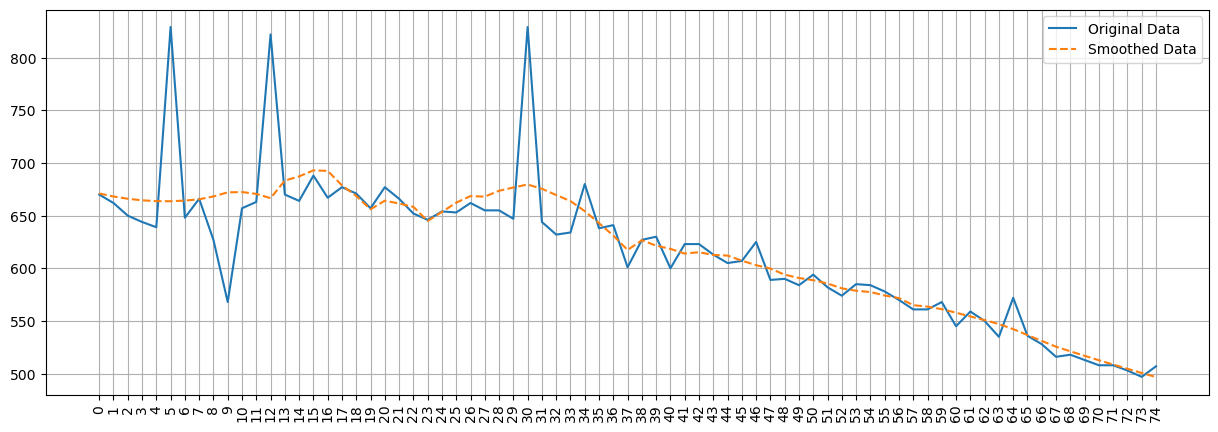

In [76]:
# Smooth the data using a Savitzky-Golay filter
window_length = 15  # Adjust the window length as needed
smoothed_data = savgol_filter(n_masks_per_frame, window_length, 2)  # The '2' is the order of the smoothing

# Set the figure size
plt.figure(figsize=(15, 5))  # Adjust the width (10) and height (5) as needed

# Plot the original data
plt.plot(n_masks_per_frame, label='Original Data')

# Plot the smoothed data on top
plt.plot(smoothed_data, label='Smoothed Data', linestyle='--')

# Specify the locations of vertical grid lines
x_values = range(len(n_masks_per_frame))
plt.xticks(x_values, rotation=90)  # Rotate x-labels by 90 degrees

# Add grid lines
plt.grid()

# Add a legend to differentiate between the original and smoothed data
plt.legend()

# Show the plot
plt.show()

(array([832., 244., 199., 117.,  68.,  70.,  86.,  66.,  69.,  49.]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <BarContainer object of 10 artists>)

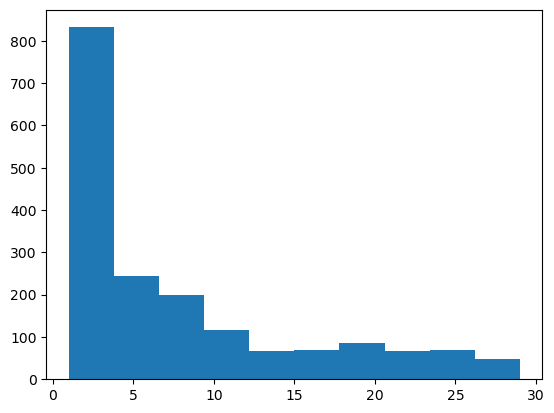

In [52]:
plt.hist([len(t) for t in tracks if len(t) <30])

In [49]:
# broadly speaking efferocytotic tracks will not last the whole time lapse... 
# also they will need at least 3 frame to guarantee merging
# and i want them to be at least 10 frames long as it looks like 
poss_eff_tracks = [t for t in tracks if len(t) <= 71]

In [50]:
len(poss_eff_tracks)

2221